In [323]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [324]:
# load dataset
df = pd.read_csv('./train_MpHjUjU.csv')

In [325]:
df.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1


# As seen above we have multiple records for a single employee - 
# like a time series
Let's check how unique employee data

In [326]:
# total number of unique employees in dataset
len(df['Emp_ID'].value_counts())

2381

In [327]:
# number of employees that quit
df.shape[0]-df['LastWorkingDate'].isna().sum()

1616

In [328]:
# number of employees still working
2381-1616

765

# Since we want to predict when an employee will quit, we need to use the data of employees that already quit to build our model
# i.e we have 1616 employees data to use

In [329]:
# function to convert date columns to datetime objects

def convert_date_cols(df):
    df1 = df.copy()
    # convert the dates to datetime objects
    df1['LastWorkingDate'] = pd.to_datetime(df1['LastWorkingDate'])
    df1['MMM-YY'] = pd.to_datetime(df1['MMM-YY'])
    df1['Dateofjoining'] = pd.to_datetime(df1['Dateofjoining'])
    return df1


In [330]:
# function to fetch data of the employees that already quit

def get_quit_emps_data(df):
    df1 = df.copy()
    # get data of employees that quit
    df1 = df1[~df1['LastWorkingDate'].isna()]
    print(df1['LastWorkingDate'].isna().sum())
    
    # create a dictionary to store the last working date for respective employees
    emp_last_date = pd.Series(df1['LastWorkingDate'].values, index=df1['Emp_ID']).to_dict()
    
    # now let's get these employee ids
    employees_left = df1['Emp_ID'].unique()
    
    # Create dataframe with all records of the employees that quit from the originl dataset
    df2 = df[df['Emp_ID'].apply(lambda x: x in employees_left)]

    return df2, emp_last_date, employees_left

In [331]:
# function to process the dataframe

def process_df(df, emp_last_date):
    df1 = df.copy()
    # fill NaT values with last date for each entry of each employee
    df1['LastWorkingDate'] = df1.apply(lambda x: emp_last_date[x['Emp_ID']], axis=1)
    
    # create a new column to measure days left to quit for each entry
    df1['DaysToQuit'] = (df1['LastWorkingDate']-df1['MMM-YY']).dt.days
    
    # create another column to measure each entry's tenure
    df1['Tenure'] = (df1['MMM-YY']-df1['Dateofjoining']).dt.days
    
    return df1

In [332]:
# function to encode categorical columns

def convert_categorical_cols(df):
    df1 = df.copy()
    # All cities have similar population - Binning can be an option, but for now they are encoded individually
    dummy_cols = pd.get_dummies(df1['City'], drop_first=True)
    df1 = pd.concat([df1, dummy_cols], axis=1)
    
    # Gender is considered a binomial category
    df1['Gender'] = df1['Gender'].apply(lambda x: 1 if x=='Male' else 0)
    
    # Education_Level is considered as ordinal data
    df1['Education_Level']= df1['Education_Level'].map({'Master':2, 'College':0, 'Bachelor':1})
    
    return df1

In [333]:
df1 = convert_date_cols(df)

In [334]:
df2, emp_last_date, employees_left = get_quit_emps_data(df1)

0


In [335]:
df2.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
5,2016-12-01,4,43,Male,C13,Master,65603,2016-12-07,NaT,2,2,0,1
6,2017-01-01,4,43,Male,C13,Master,65603,2016-12-07,NaT,2,2,0,1


In [336]:
df3 = process_df(df2, emp_last_date)

In [337]:
df3.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating,DaysToQuit,Tenure
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,2381060,2,70,8
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,-665480,2,39,39
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2,10,68
5,2016-12-01,4,43,Male,C13,Master,65603,2016-12-07,2017-04-27,2,2,0,1,147,-6
6,2017-01-01,4,43,Male,C13,Master,65603,2016-12-07,2017-04-27,2,2,0,1,116,25


In [338]:
df4 = convert_categorical_cols(df3)

In [339]:
df4.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,...,C27,C28,C29,C3,C4,C5,C6,C7,C8,C9
0,2016-01-01,1,28,1,C23,2,57387,2015-12-24,2016-03-11,1,...,0,0,0,0,0,0,0,0,0,0
1,2016-02-01,1,28,1,C23,2,57387,2015-12-24,2016-03-11,1,...,0,0,0,0,0,0,0,0,0,0
2,2016-03-01,1,28,1,C23,2,57387,2015-12-24,2016-03-11,1,...,0,0,0,0,0,0,0,0,0,0
5,2016-12-01,4,43,1,C13,2,65603,2016-12-07,2017-04-27,2,...,0,0,0,0,0,0,0,0,0,0
6,2017-01-01,4,43,1,C13,2,65603,2016-12-07,2017-04-27,2,...,0,0,0,0,0,0,0,0,0,0


In [340]:
# dropping rows that have just 1 entry per employee
df4 =df4.groupby('Emp_ID').filter(lambda x: len(x)>1)

In [341]:
# drop the unnecessary columns in the dataset
df4.drop(['LastWorkingDate', 'MMM-YY', 'Dateofjoining', 'City'], axis=1, inplace=True)
df4.head()

,Emp_ID,Age,Gender,Education_Level,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,DaysToQuit,...,C27,C28,C29,C3,C4,C5,C6,C7,C8,C9
0,1,28,1,2,57387,1,1,2381060,2,70,...,0,0,0,0,0,0,0,0,0,0
1,1,28,1,2,57387,1,1,-665480,2,39,...,0,0,0,0,0,0,0,0,0,0
2,1,28,1,2,57387,1,1,0,2,10,...,0,0,0,0,0,0,0,0,0,0
5,4,43,1,2,65603,2,2,0,1,147,...,0,0,0,0,0,0,0,0,0,0
6,4,43,1,2,65603,2,2,0,1,116,...,0,0,0,0,0,0,0,0,0,0


# Creating a risk column with this condition
# Since Q1 and Q2 are to be considered - i.e. approx - 6 months ~ 180 days
# if days to quit is less than 180 then risk = 1 else 0

In [342]:
# create risk column with this condition
# Since Q1 and Q2 are to be considered - i.e. approx - 6 months ~ 180 days
# if days to quit is less than 180 then risk = 1 else 0
df4['Risk'] = df4['DaysToQuit'].apply(lambda x: 1 if x<180 else 0)
df4.head()
df4.drop(['DaysToQuit'], axis=1, inplace=True)

In [343]:
x=df4.groupby('Emp_ID')['Risk'].value_counts()

In [344]:
x.head(10)

Emp_ID  Risk
1       1        3
4       1        5
5       1        3
8       1        3
12      1        6
13      0       17
        1        6
16      1        2
17      1        6
        0        1
Name: Risk, dtype: int64

# The number of available enteries for each employee is different and hence causes imbalance

# To balance it out, I will grab the first entry of an employee i.e ideally with risk=0 and the last entry with risk=1

In [345]:
g = df4.groupby('Emp_ID')

df4 = pd.concat([g.head(1), g.tail(1)]).drop_duplicates().sort_values('Emp_ID').reset_index(drop=True)
df4

,Emp_ID,Age,Gender,Education_Level,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenure,...,C28,C29,C3,C4,C5,C6,C7,C8,C9,Risk
0,1,28,1,2,57387,1,1,2381060,2,8,...,0,0,0,0,0,0,0,0,0,1
1,1,28,1,2,57387,1,1,0,2,68,...,0,0,0,0,0,0,0,0,0,1
2,4,43,1,2,65603,2,2,0,1,115,...,0,0,0,0,0,0,0,0,0,1
3,4,43,1,2,65603,2,2,0,1,-6,...,0,0,0,0,0,0,0,0,0,1
4,5,29,1,0,46368,1,1,0,1,-8,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3023,2785,34,0,0,12105,1,1,0,1,-27,...,0,0,0,0,0,0,0,0,1,1
3024,2786,45,1,0,35370,2,2,0,1,398,...,0,0,0,0,0,0,0,0,0,1
3025,2786,44,1,0,35370,2,2,221080,2,154,...,0,0,0,0,0,0,0,0,0,0
3026,2787,28,0,2,69498,1,1,408090,2,164,...,0,0,0,0,0,0,0,0,0,1


In [346]:
df5['Risk'].value_counts()

1    2465
0     563
Name: Risk, dtype: int64

In [347]:
# Slicing the dataframe to predictors and target
X = df4.drop(['Risk'], axis=1)
y = df4['Risk']

# Split the dataset into train and test with shuffle=False to avoid the same employee records splitting up
# Ideally we should have both records in either test or train dataset

In [348]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27, shuffle=False)

In [349]:
X_train['Emp_ID'].value_counts()

2047    2
1300    2
1306    2
1308    2
1312    2
       ..
613     2
615     2
621     2
623     2
2049    2
Name: Emp_ID, Length: 1211, dtype: int64

In [350]:
y_train.value_counts()

1    1975
0     447
Name: Risk, dtype: int64

In [351]:
# Dropping the Emp_ID columns
X_train.drop(['Emp_ID'], axis=1, inplace=True)
X_test.drop(['Emp_ID'], axis=1, inplace=True)

In [352]:
# Since there are different units for the measurements in the columns, lets scale them normally
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Model building

In [355]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as csr

from sklearn.model_selection import cross_val_score

In [ ]:
# function to plot prediciton by a given model and classification report
def prediction(model, is_svc=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = round(accuracy_score(y_test, y_pred), 3)

    cm1 = cm(y_test, y_pred)
    # plot confusion matrix
    sns.heatmap(cm1, annot=True, fmt=".0f")
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Accuracy Score: {0}'.format(score), size = 15)
    plt.show()
    
    # print classification report
    csr1 = csr(y_test, y_pred)
    print(csr1)

    y_proba = None

    if not is_svc:
        y_proba = model.predict_proba(X_test)
    else:
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)

    return y_pred, y_proba

In [451]:
def generate_submissions(model, csv_name):
    test_df = pd.read_csv(r'C:\My_drive\DS\Hackathon\test_hXY9mYw.csv')
    emp_to_predict = test_df['Emp_ID'].unique()
    
    df4 = df1[df1['Emp_ID'].apply(lambda x: x in emp_to_predict)]
    df4['Tenure'] = (df4['MMM-YY']-df4['Dateofjoining']).dt.days
    
    dummy_cols = pd.get_dummies(df4['City'], drop_first=True)
    df4 = pd.concat([df4, dummy_cols], axis=1)
    
    g = df4.groupby('Emp_ID')

    df4 = pd.concat([g.head(1), g.tail(1)]).drop_duplicates().sort_values('Emp_ID').reset_index(drop=True)
    df5=df4.copy()
    # drop the unnecessary columns in the dataset
    df4.drop(['LastWorkingDate', 'MMM-YY', 'Dateofjoining', 'City', 'Emp_ID', ], axis=1, inplace=True)
    
    df4['Gender'] = df4['Gender'].apply(lambda x: 1 if x=='Male' else 0)
    df4['Education_Level']= df4['Education_Level'].map({'Master':2, 'College':0, 'Bachelor':1})
    
    X_transformed = sc.transform(df4)
    #y_pred = model.predict(X_transformed)
    y_pred = np.where(model_lr.predict_proba(X_transformed)[:,1] > THRESHOLD, 1, 0)
    
    #df5 = df1[df1['Emp_ID'].apply(lambda x: x in emp_to_predict)]
    df5['Target'] = y_pred
    
    df5 = df5[['Emp_ID', 'Target']]
    
    df5 = df5.drop_duplicates(subset='Emp_ID', keep="last")
    path = 'C:\\My_drive\\DS\\Hackathon\\' + csv_name + '.csv'
    df5.to_csv(path, index=False)
    print(df5['Target'].value_counts())

# Let's use the simplest classification model as a benchmark

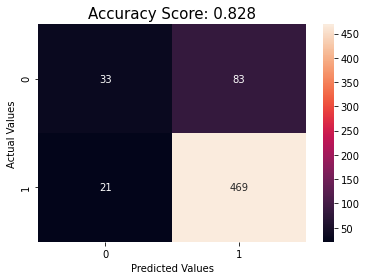

              precision    recall  f1-score   support

           0       0.61      0.28      0.39       116
           1       0.85      0.96      0.90       490

    accuracy                           0.83       606
   macro avg       0.73      0.62      0.64       606
weighted avg       0.80      0.83      0.80       606



In [441]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
y_pred_lr, y_proba_lr = prediction(model_lr)

# Looks like logistic regresssion is sufficient, 
# using gridsearch to get the optimal parameters
Also, further we can tune the threshold to extract maximum accuracy

In [442]:
from sklearn.model_selection import GridSearchCV

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)


grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.839803 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.839803 (0.001992) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.839803 (0.001992) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.839803 (0.001992) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.839803 (0.001992) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.839803 (0.001992) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.839803 (0.001992) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.839803 (0.001992) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.839803 (0.001992) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.839803 (0.001992) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.839388 (0.002445) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.839388 (0.002445) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.838975 (0.002970) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.836913 (0.003850) wit

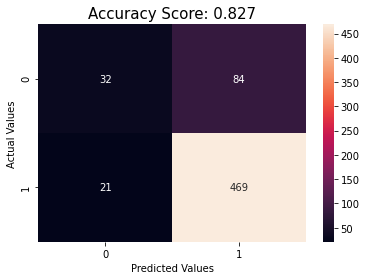

              precision    recall  f1-score   support

           0       0.60      0.28      0.38       116
           1       0.85      0.96      0.90       490

    accuracy                           0.83       606
   macro avg       0.73      0.62      0.64       606
weighted avg       0.80      0.83      0.80       606



In [445]:
# Redefining the model with the best parameters
model_lr = LogisticRegression(C=100, penalty='l2', solver= 'newton-cg')
model_lr.fit(X_train, y_train)
y_pred_lr, y_proba_lr = prediction(model_lr)

# Since the target classes are imbalanced, let's find the optimal threshold

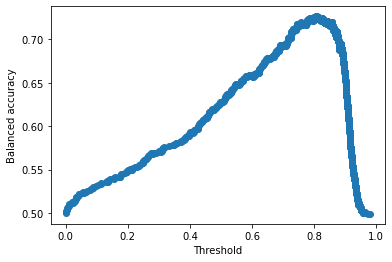

In [446]:
from sklearn.metrics import roc_curve,plot_roc_curve, balanced_accuracy_score

threshold = []
accuracy = []

for p in np.unique(model_lr.predict_proba(X_train)[:,1]):
  threshold.append(p)
  y_pred = (model_lr.predict_proba(X_train)[:,1] >= p).astype(int)
  accuracy.append(balanced_accuracy_score(y_train,y_pred))

plt.scatter(threshold,accuracy)
plt.xlabel("Threshold")
plt.ylabel("Balanced accuracy")
plt.show()

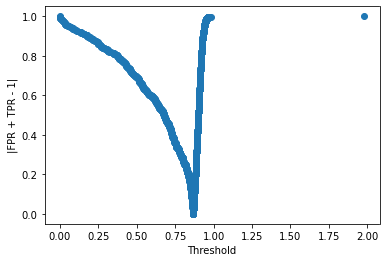

In [447]:
fpr, tpr, thresholds = roc_curve(y_train,model_lr.predict_proba(X_train)[:,1],drop_intermediate=False)
plt.scatter(thresholds,np.abs(fpr+tpr-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.show()

In [448]:
# From the plots, we see that the optimal threshold is around 0.8

THRESHOLD = 0.8
preds = np.where(model_lr.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

print(csr(y_test, preds))

              precision    recall  f1-score   support

           0       0.50      0.59      0.54       116
           1       0.90      0.86      0.88       490

    accuracy                           0.81       606
   macro avg       0.70      0.72      0.71       606
weighted avg       0.82      0.81      0.82       606



# As seen, the f1 score for zero class has improved significantly

In [453]:
# Lets generate the results for test employee ids
generate_submissions(model_lr, 'model_lr')

0    380
1    361
Name: Target, dtype: int64
